# Lecture 36 - Model Selection Hackery: Hyperparameter Tuning

#### Announcements:
* MS1 feedback is out for some groups; out for remaining groups by end of today
* Data ethics 3 - released today/tomorrow, discussion in class Wednesday 12/1; there will be a small graded in-class writing response, so you should show up that day.
    * details forthcoming, but you'll be reading [this](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) article on bias in machine learning systems.

#### Goals:
* Understand what is meant by "hyperparameters" when developing ML models
* Know how to engage in a few types of "model selection hackery", including hyperparameter tuning and search (grid, random, etc.)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
def scale_split(ds):
    """ Apply standard scaling and split into train/val sets."""
    X, y = ds
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
    Xtr, Xva, ytr, yva = train_test_split(Xtr, ytr, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    Xtr = scaler.fit_transform(Xtr)
    Xva = scaler.transform(Xva)
    Xte = scaler.transform(Xte)

    return (Xtr, Xva, Xte, ytr, yva, yte)



In [6]:
forest = sklearn.datasets.fetch_covtype(as_frame=True)
forest["frame"]

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0          2596.0    51.0    3.0                             258.0   
1          2590.0    56.0    2.0                             212.0   
2          2804.0   139.0    9.0                             268.0   
3          2785.0   155.0   18.0                             242.0   
4          2595.0    45.0    2.0                             153.0   
...           ...     ...    ...                               ...   
581007     2396.0   153.0   20.0                              85.0   
581008     2391.0   152.0   19.0                              67.0   
581009     2386.0   159.0   17.0                              60.0   
581010     2384.0   170.0   15.0                              60.0   
581011     2383.0   165.0   13.0                              60.0   

        Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                  0.0                            510.0   
1                                 -6.0                            390.0   
2                                 65.0                           3180.0   
3                                118.0                           3090.0   
4                                 -1.0                            391.0   
...                                ...                              ...   
581007                            17.0                            108.0   
581008                            12.0                             95.0   
581009                             7.0                             90.0   
581010                             5.0                             90.0   
581011                             4.0                             67.0   

        Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0               221.0           232.0          148.0   
1               220.0           235.0          151.0   
2               234.0           238.0          135.0   
3               238.0           238.0          122.0   
4               220.0           234.0          150.0   
...               ...             ...            ...   
581007          240.0           237.0          118.0   
581008          240.0           237.0          119.0   
581009          236.0           241.0          130.0   
581010          230.0           245.0          143.0   
581011          231.0           244.0          141.0   

        Horizontal_Distance_To_Fire_Points  ...  Soil_Type_31  Soil_Type_32  \
0                                   6279.0  ...           0.0           0.0   
1                                   6225.0  ...           0.0           0.0   
2                                   6121.0  ...           0.0           0.0   
3                                   6211.0  ...           0.0           0.0   
4                                   6172.0  ...           0.0           0.0   
...                                    ...  ...           ...           ...   
581007                               837.0  ...           0.0           0.0   
581008                               845.0  ...           0.0           0.0   
581009                               854.0  ...           0.0           0.0   
581010                               864.0  ...           0.0           0.0   
581011                               875.0  ...           0.0           0.0   

        Soil_Type_33  Soil_Type_34  Soil_Type_35  Soil_Type_36  Soil_Type_37  \
0                0.0           0.0           0.0           0.0           0.0   
1                0.0           0.0           0.0           0.0           0.0   
2                0.0           0.0           0.0           0.0           0.0   
3                0.0           0.0           0.0           0.0           0.0   
4                0.0           0.0           0.0           0.0           0.0   
...              ...           ...           ...           ...           ...   
581007           0.0           0.0           0.0           0.0           0.0   
5810

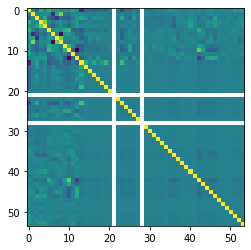

In [7]:
X = forest["data"].sample(n=3000, random_state=42)
y = forest["target"].sample(n=3000, random_state=42)
plt.imshow(X.corr().to_numpy())

In [8]:
(Xtrain, Xval, Xtest, ytrain, yval, ytest) = scale_split((X, y))

<AxesSubplot:xlabel='Cover_Type', ylabel='Count'>

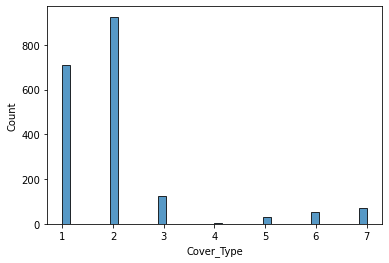

In [9]:
sns.histplot(ytrain)

In [10]:
def run_eval(clf, Xtrain, ytrain, Xval, yval):
    def model_outputs(clf, X):
        if hasattr(clf, "decision_function"):
            return clf.decision_function(X)
        else:
            return clf.predict_proba(X)
        
    ytrain_pred = clf.predict(Xtrain)
    yval_pred = clf.predict(Xval)
    
    train_outputs = model_outputs(clf, Xtrain)
    val_outputs = model_outputs(clf, Xval)
    
    return (ytrain_pred, yval_pred, train_outputs, val_outputs)

def show_eval(eval_results, ytrain, yval):
    """ show the results of evaluating a model; eval_results should be:
        (ytrain_pred, yval_pred, train_outputs, val_outputs) as constructed
        by run_eval """
    (ytrain_pred, yval_pred, train_outputs, val_outputs) = eval_results

    confusion = confusion_matrix(yval, yval_pred)
    ConfusionMatrixDisplay(confusion).plot()
    return pd.DataFrame([
        ["Accuracy", accuracy_score(ytrain, ytrain_pred), accuracy_score(yval, yval_pred)],
        ["Top-2 Acc", top_k_accuracy_score(ytrain, train_outputs, k=2),
                      top_k_accuracy_score(yval, val_outputs, k=2)],
        ["Top-3 Acc", top_k_accuracy_score(ytrain, train_outputs, k=3),
                      top_k_accuracy_score(yval, val_outputs, k=3)]]
        ).rename(columns={1: "Train", 2: "Val"})


0     Train       Val
0   Accuracy  0.482292  0.443750
1  Top-2 Acc  0.851562  0.833333
2  Top-3 Acc  0.917188  0.897917

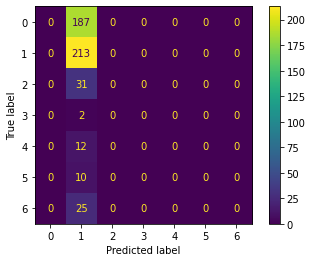

In [11]:
# mode baseline:
# predictions: just always say 2
ytrain_mode = 2*np.ones_like(ytrain)
yval_mode = 2*np.ones_like(yval)

# model probabilities/scores: assign score 1 to label 2, 0 to all others
train_outputs_mode = np.zeros((Xtrain.shape[0], 7))
train_outputs_mode[:, 1] = 1
train_outputs_mode[:, 0] = .5
train_outputs_mode[:, 2] = .2

val_outputs_mode = np.zeros((Xval.shape[0], 7))
val_outputs_mode[:, 1] = 1
val_outputs_mode[:, 0] = .5
val_outputs_mode[:, 2] = .2

show_eval((ytrain_mode, yval_mode, train_outputs_mode, val_outputs_mode), ytrain, yval)

### Let's do some model development!

C = 1e-05
           0     Train       Val
0   Accuracy  0.482292  0.443750
1  Top-2 Acc  0.851562  0.833333
2  Top-3 Acc  0.917188  0.897917
C = 0.0001
           0     Train       Val
0   Accuracy  0.482292  0.443750
1  Top-2 Acc  0.851562  0.833333
2  Top-3 Acc  0.917188  0.897917
C = 0.001
           0     Train       Val
0   Accuracy  0.656771  0.610417
1  Top-2 Acc  0.924479  0.904167
2  Top-3 Acc  0.969271  0.956250
C = 0.01
           0     Train       Val
0   Accuracy  0.714063  0.677083
1  Top-2 Acc  0.959896  0.937500
2  Top-3 Acc  0.990104  0.985417
C = 0.1
           0     Train       Val
0   Accuracy  0.743750  0.700000
1  Top-2 Acc  0.964583  0.943750
2  Top-3 Acc  0.993750  0.991667
C = 1
           0     Train       Val
0   Accuracy  0.749479  0.704167
1  Top-2 Acc  0.976042  0.945833
2  Top-3 Acc  0.998958  0.995833
C = 10
           0     Train       Val
0   Accuracy  0.755729  0.710417
1  Top-2 Acc  0.981771  0.947917
2  Top-3 Acc  0.999479  0.991667


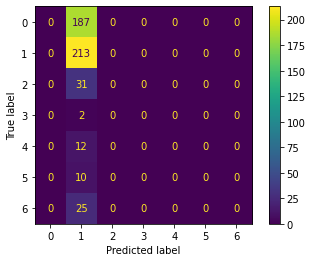

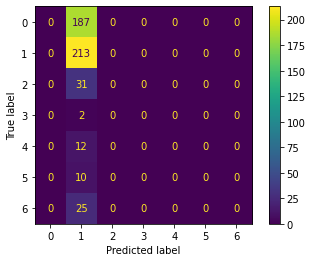

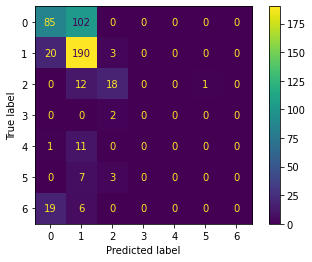

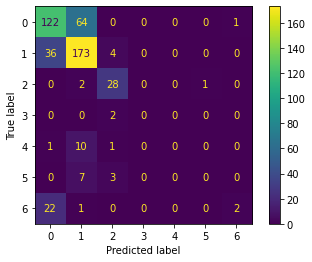

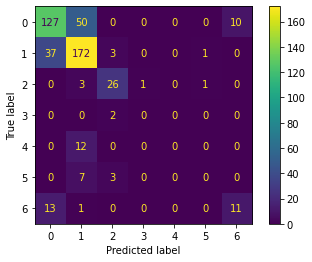

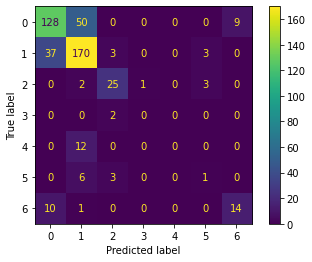

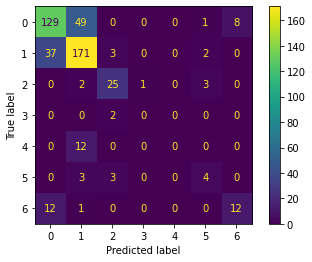

In [16]:
for i in range(7):
    p = i - 5
    clf = SVC(kernel="linear", C=10**p)
    clf.fit(Xtrain, ytrain)

    eval_results = run_eval(clf, Xtrain, ytrain, Xval, yval)
    print(f"C = {10**p}")
    print(show_eval(eval_results, ytrain, yval))

In [13]:
classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Logistic Regression": LogisticRegression(),
    "Linear SVM": SVC(kernel="linear", C=0.025),
    "RBF SVM": SVC(gamma=2, C=1),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "Neural Network": MLPClassifier((20, 100), alpha=1, max_iter=1000),
    "Naive Bayes": GaussianNB(),
}